In [1]:
%load_ext autoreload
%autoreload 2

# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from scipy import stats
from scipy.ndimage import gaussian_filter 
from sklearn.neighbors import KernelDensity
import seaborn as sns
import plotly.graph_objects as go

In [35]:
season_year = 2017
season_type = "Regular"

In [36]:
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()

In [37]:
dir_df = os.path.join(data_manager.data_dir, str(season_year), season_type, 'DataFrame')
filename = f'data_season_df_{season_year}_{season_type}.json'
path_df = os.path.join(dir_df, filename)
if os.path.exists(path_df):
    data_season_df = pd.read_json(path_df, dtype=False)
else:
    os.makedirs(dir_df, exist_ok=True)

    game_numbers = data_manager.get_game_numbers_from_data(season_year=season_year, season_type=season_type)
    data_season_df = data_manager.get_goals_and_shots_df_standardised(season_year=season_year, season_type=season_type, game_number=game_numbers[0])

    for game_number in game_numbers[1:]:
        data_season_df = pd.concat([data_season_df, data_manager.get_goals_and_shots_df_standardised(season_year=season_year, season_type=season_type, game_number=game_number)], ignore_index=True)

    data_season_df.to_json(path_df, indent=4)

In [47]:
data_season_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81873 entries, 0 to 81872
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Game ID      81873 non-null  object
 1   Event Index  81873 non-null  object
 2   Time         81873 non-null  object
 3   Period       81873 non-null  object
 4   Team         81873 non-null  object
 5   Type         81873 non-null  object
 6   Shot Type    81873 non-null  object
 7   Shooter      81873 non-null  object
 8   Goalie       81873 non-null  object
 9   Empty Net    7691 non-null   object
 10  Strength     7691 non-null   object
 11  X            81865 non-null  object
 12  Y            81865 non-null  object
 13  st_X         79302 non-null  object
 14  st_Y         79302 non-null  object
dtypes: object(15)
memory usage: 9.4+ MB


In [48]:
total_shots_league = len(data_season_df)
number_of_games = len(data_season_df['Game ID'].unique())
print(f'Total number of shots during season {season_year} ({season_type}) = {total_shots_league}')
print(f'Number of games during season {season_year} ({season_type}) = {number_of_games}')

mean_shots_per_hour = total_shots_league / (2*number_of_games)
print(f'Mean shots by team by hour during season {season_year} ({season_type}) = {mean_shots_per_hour}')

total_goals_league = len(data_season_df[data_season_df['Type'] == 'GOAL'])
mean_goals_per_hour = total_goals_league / (2*number_of_games)
print(f'Mean goals by team by hour during season {season_year} ({season_type}) = {mean_goals_per_hour}')


Total number of shots during season 2017 (Regular) = 81873
Number of games during season 2017 (Regular) = 1271
Mean shots by team by hour during season 2017 (Regular) = 32.2081038552321
Mean goals by team by hour during season 2017 (Regular) = 3.0255704169944924


In [49]:
list_of_teams = data_season_df['Team'].unique()
number_of_teams = len(list_of_teams)

print(f'Number of Teams during season {season_year} ({season_type}) = {number_of_teams}')

Number of Teams during season 2017 (Regular) = 31


In [50]:
# Compute the number of games played for each team. Should be 82, but could be less or maybe even different for each team (COVID etc.)
df_number_of_games_by_team = data_season_df[['Team', 'Game ID']].groupby('Team').describe()['Game ID']['unique']
df_number_of_games_by_team = df_number_of_games_by_team.sort_index(ascending=True)
df_number_of_games_by_team.head()

Team
Anaheim Ducks (ANA)      82
Arizona Coyotes (ARI)    82
Boston Bruins (BOS)      82
Buffalo Sabres (BUF)     82
Calgary Flames (CGY)     82
Name: unique, dtype: object

In [51]:
df_total_shots_season_by_team = data_season_df.groupby('Team').size()
df_total_shots_season_by_team = df_total_shots_season_by_team.sort_index(ascending=True)
df_total_shots_season_by_team.head(5)

Team
Anaheim Ducks (ANA)      2514
Arizona Coyotes (ARI)    2472
Boston Bruins (BOS)      2722
Buffalo Sabres (BUF)     2565
Calgary Flames (CGY)     2777
dtype: int64

In [52]:
data_season_goal = data_season_df.loc[data_season_df['Type'] == 'GOAL']
data_season_goal.groupby('Team').size()
data_season_goal = data_season_goal.sort_index(ascending=True)
data_season_goal.head(5)

# This is pretty consistent with https://www.nhl.com/standings/2021/league

,Game ID,Event Index,Time,Period,Team,Type,Shot Type,Shooter,Goalie,Empty Net,Strength,X,Y,st_X,st_Y
0,2017020001,93,15:45,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Nazem Kadri,Steve Mason,False,Power Play,84.0,-6.0,84.0,-6.0
1,2017020001,108,17:40,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,James van Riemsdyk,Steve Mason,False,Even,62.0,5.0,62.0,5.0
2,2017020001,112,18:23,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,William Nylander,Steve Mason,False,Even,84.0,-22.0,84.0,-22.0
3,2017020001,157,08:32,2,Toronto Maple Leafs (TOR),GOAL,Backhand,Patrick Marleau,Steve Mason,False,Even,-82.0,2.0,82.0,-2.0
4,2017020001,225,00:36,3,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Patrick Marleau,Steve Mason,False,Even,68.0,12.0,68.0,12.0


In [53]:
df_mean_shots_per_team_by_hour = df_total_shots_season_by_team.sort_index(ascending=True) / df_number_of_games_by_team.sort_index(ascending=True)
print(df_mean_shots_per_team_by_hour.head(5))
# This is pretty consistent with https://www.statmuse.com/nhl/ask?q=nhl+team+stats+shots+per+game+2021-22

Team
Anaheim Ducks (ANA)      30.658537
Arizona Coyotes (ARI)    30.146341
Boston Bruins (BOS)      33.195122
Buffalo Sabres (BUF)     31.280488
Calgary Flames (CGY)     33.865854
dtype: object


In [54]:
x_shots_season = data_season_df['st_X'].dropna().to_numpy().copy().astype(np.float32)
y_shots_season = data_season_df['st_Y'].dropna().to_numpy().copy().astype(np.float32)

# mask_defensive = (x_shots_season < 0) & (x_shots_season > 89)
# x_shots_season = x_shots_season[mask_offensive]
# y_shots_season = y_shots_season[mask_offensive]
# x_shots_season[mask_defensive] = 0
# y_shots_season[mask_defensive] = 0

number_of_games = len(data_season_df['Game ID'].unique())

print(f'Number of games in season {season_year} ({season_type}) = {number_of_games}')
print(f'Number of shots from offensive zone in season {season_year} ({season_type}) = {len(x_shots_season)}')

Number of games in season 2017 (Regular) = 1271
Number of shots from offensive zone in season 2017 (Regular) = 79302


In [55]:
print(x_shots_season.mean(), y_shots_season.mean())


58.06977 -0.12980758


In [56]:
# data_one_team_df = data_season_df.loc[data_season_df['Team'] == "Buffalo Sabres (BUF)"]
data_one_team_df = data_season_df.loc[data_season_df['Team'] == "San Jose Sharks (SJS)"]
# data_one_team_df = data_season_df.loc[data_season_df['Team'] == "Anaheim Ducks (ANA)"]

x_shots_one_team = data_one_team_df['st_X'].dropna().to_numpy().copy().astype(np.float32)
y_shots_one_team = data_one_team_df['st_Y'].dropna().to_numpy().copy().astype(np.float32)


# mask_defensive = (x_shots_one_team < 0) & (x_shots_one_team > 89)
# y_shots_season = y_shots_season[mask_offensive]
# x_shots_one_team[mask_defensive] = 0
# x_shots_one_team[mask_defensive] = 0


In [57]:
def get_shots_hist2D(x_shots, y_shots, num_pts_x=20, num_pts_y=20):

    # We are only interested in shots in offensive zone, so we don't care about negative x coordinates
    x_min, x_max = 0.0, 100.
    y_min, y_max = -42.5, 42.5

    delta_x = (x_max-x_min) / num_pts_x
    delta_y = (y_max-y_min) / num_pts_y

    x_grid = np.arange(x_min-delta_x, x_max+delta_x, delta_x)
    y_grid = np.arange(y_min-delta_y, y_max+delta_y, delta_y)

    # ret = stats.binned_statistic_2d(x_shots.tolist(), y_shots.tolist(), None, 'count', bins=[x_grid.tolist(), y_grid.tolist()])
    H, x_edge, y_edge = np.histogram2d(x_shots, y_shots, bins=[x_grid, y_grid])
    
    return H.T, x_edge[1:], y_edge[1:]


In [58]:
shots_hist2D_season, x_bins, y_bins = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=20, num_pts_y=20)
print(shots_hist2D_season.sum())
# We lost some shots, but they have benn taken from the defensize zone

77365.0


In [59]:
print(x_bins)
print(y_bins)

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]
[-42.5  -38.25 -34.   -29.75 -25.5  -21.25 -17.   -12.75  -8.5   -4.25
   0.     4.25   8.5   12.75  17.    21.25  25.5   29.75  34.    38.25
  42.5 ]


In [60]:
shots_hist2D_season, _, _ = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=20, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_season_by_hour.sum()

30.434697088906372

In [61]:
np.where(shots_hist2D_season == 0)
# Great, we don't have zero value

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  1,  1,  2,  3,  4,  5,  6, 10, 12, 18, 19, 20,
        20]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20,  5, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19,
        20]))

1.2560975609756098
0.970102281667978


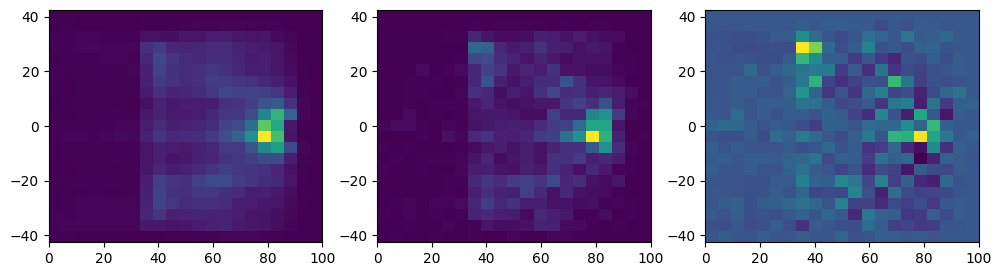

In [62]:
number_of_games_by_team = df_number_of_games_by_team.mean()

shots_hist2D_season, x_edge, y_edge = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=20, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_one_team, x_edge, y_edge = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=20, num_pts_y=20)
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / number_of_games_by_team

fig, ax = plt.subplots(1, 3, figsize=(12,12))

# ax[0].imshow(shots_hist2D_season_by_hour, extent=[0, 89, -42.5, 42.5])
# ax[1].imshow(shots_hist2D_one_team_by_hour, extent=[0, 89, -42.5, 42.5])
# ax[2].imshow(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, extent=[0, 89, -42.5, 42.5])

ax[0].imshow(shots_hist2D_season_by_hour, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
ax[1].imshow(shots_hist2D_one_team_by_hour, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
ax[2].imshow(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
print(shots_hist2D_one_team_by_hour.max())
print(shots_hist2D_season_by_hour.max())
plt.show()


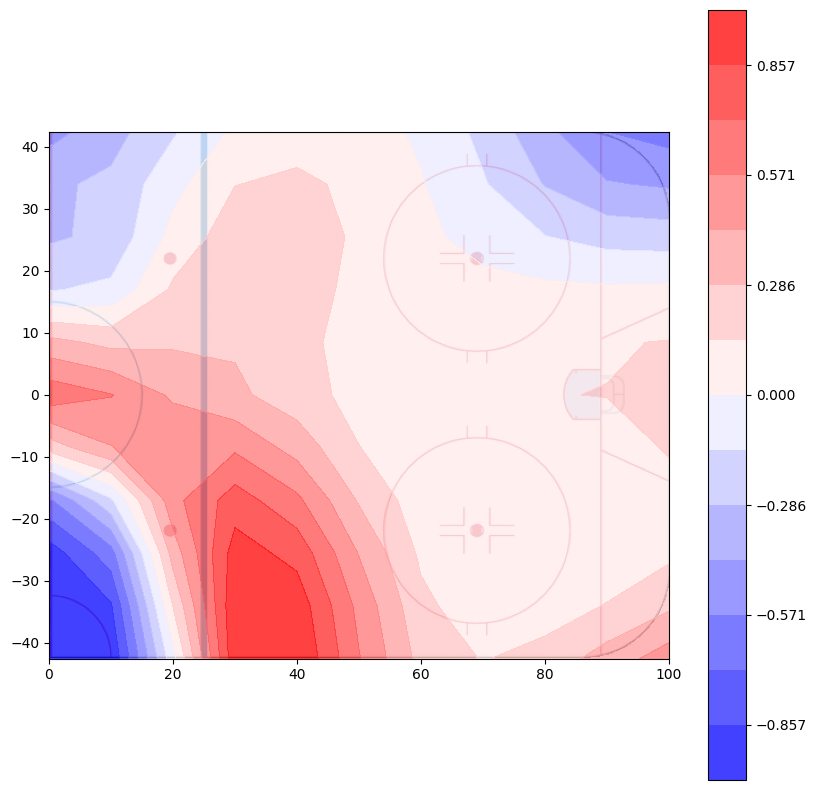

In [63]:

shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=10, num_pts_y=10)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=10, num_pts_y=10)
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)

shots_hist2D_one_team_by_hour_s = gaussian_filter(shots_hist2D_one_team_by_hour, sigma = 1.1)
shots_hist2D_season_by_hour_s = gaussian_filter(shots_hist2D_season_by_hour, sigma = 1.1)

diff = (shots_hist2D_one_team_by_hour_s-shots_hist2D_season_by_hour_s) / shots_hist2D_season_by_hour_s
# diff = gaussian_filter(diff, sigma = 1.1)

# Not necessary
diff_min = diff.min()
diff_max = diff.max()
alpha = (-2./(diff_min-diff_max)) 
beta = (diff_min + diff_max) / (diff_min - diff_max)
diff_norm = alpha * diff + beta

rink_img = (255 * mpimg.imread("./figures/nhl_rink.png")).astype(int)
(h, w, c) = rink_img.shape
rink_half_img = rink_img[:, int(w/2):, :]
# rink_half_img = ndimage.rotate(rink_half_img, 90).astype(int)


fig = plt.figure(figsize=(10,10))
plt.contourf(x_grid, y_grid, diff_norm, alpha=0.8, cmap='bwr', levels = np.linspace(diff_norm.min(), diff_norm.max(), 15))
# plt.colorbar(orientation = 'vertical')
plt.colorbar(boundaries=np.linspace(-1, 1, 5))
# plt.clim(vmin = -1, vmax = 1)

plt.imshow(rink_half_img, extent=[0, 100,-42.5, 42.5])

# plt.contourf(y_grid, x_grid, diff_norm, alpha=0.8, cmap='bwr', levels = np.linspace(-1, 1, 20))




In [64]:
np.linspace(-1, 1, 10)

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

In [65]:
shots_hist2D_season_by_hour.max()

2.154996066089693

In [66]:
np.sort(data_season_df['Team'].unique())

array(['Anaheim Ducks (ANA)', 'Arizona Coyotes (ARI)',
       'Boston Bruins (BOS)', 'Buffalo Sabres (BUF)',
       'Calgary Flames (CGY)', 'Carolina Hurricanes (CAR)',
       'Chicago Blackhawks (CHI)', 'Colorado Avalanche (COL)',
       'Columbus Blue Jackets (CBJ)', 'Dallas Stars (DAL)',
       'Detroit Red Wings (DET)', 'Edmonton Oilers (EDM)',
       'Florida Panthers (FLA)', 'Los Angeles Kings (LAK)',
       'Minnesota Wild (MIN)', 'Montréal Canadiens (MTL)',
       'Nashville Predators (NSH)', 'New Jersey Devils (NJD)',
       'New York Islanders (NYI)', 'New York Rangers (NYR)',
       'Ottawa Senators (OTT)', 'Philadelphia Flyers (PHI)',
       'Pittsburgh Penguins (PIT)', 'San Jose Sharks (SJS)',
       'St. Louis Blues (STL)', 'Tampa Bay Lightning (TBL)',
       'Toronto Maple Leafs (TOR)', 'Vancouver Canucks (VAN)',
       'Vegas Golden Knights (VGK)', 'Washington Capitals (WSH)',
       'Winnipeg Jets (WPG)'], dtype=object)

In [67]:
(shots_hist2D_season / (number_of_games*2)).max()

shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=15, num_pts_y=15)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)
shots_hist2D_season_by_hour_s = gaussian_filter(shots_hist2D_season_by_hour, sigma = 1.5)

print(shots_hist2D_season_by_hour.max())

1.1860739575137687


(16, 16)
nan


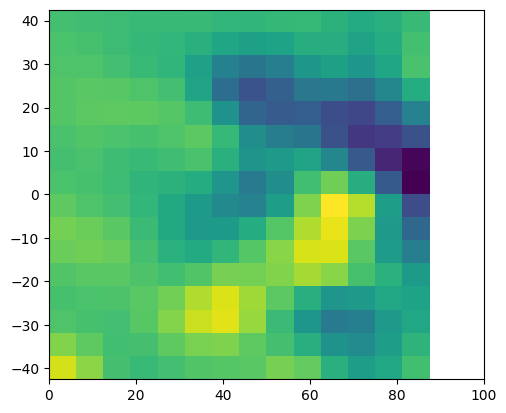

In [68]:
df_diff = pd.DataFrame(index=data_season_df['Team'].unique(), columns=['Diff'])

teams = data_season_df['Team'].unique()

for team in teams:

   data_one_team_df = data_season_df.loc[data_season_df['Team'] == team]

   x_shots_one_team = data_one_team_df['st_X'].dropna().to_numpy().copy().astype(np.float32)
   y_shots_one_team = data_one_team_df['st_Y'].dropna().to_numpy().copy().astype(np.float32)

   shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=15, num_pts_y=15)
   shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)

   diff = gaussian_filter(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, 1.)
   # diff = (shots_hist2D_one_team_by_hour_s-shots_hist2D_season_by_hour_s) / shots_hist2D_season_by_hour_s

   diff_min = diff.min()
   diff_max = diff.max()
   alpha = (-2./(diff_min-diff_max)) 
   beta = (diff_min + diff_max) / (diff_min - diff_max)
   diff_norm = alpha * diff + beta

   mask = np.where(x_grid > 89)
   diff_norm[:, mask] = 0
   df_diff.loc[team]['Diff'] = diff_norm

df_diff = df_diff.sort_index()

print(df_diff.iloc[0]['Diff'].shape)

mask = np.where(x_grid > 89)
diff_norm[:, mask] = None
print(diff_norm.sum())

plt.imshow(diff_norm, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])





In [80]:
num_pts_x=20
num_pts_y=20

shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=num_pts_x, num_pts_y=num_pts_y)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

dict_diff = {}

teams = data_season_df['Team'].unique()

for team in teams:

   data_one_team_df = data_season_df.loc[data_season_df['Team'] == team]

   x_shots_one_team = data_one_team_df['st_X'].dropna().to_numpy().copy().astype(np.float32)
   y_shots_one_team = data_one_team_df['st_Y'].dropna().to_numpy().copy().astype(np.float32)

   shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=num_pts_x, num_pts_y=num_pts_y)
   shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)

   diff = gaussian_filter(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, 1.)
   # diff = (shots_hist2D_one_team_by_hour_s-shots_hist2D_season_by_hour_s) / shots_hist2D_season_by_hour_s

   diff_min = diff.min()
   diff_max = diff.max()
   alpha = (-2./(diff_min-diff_max)) 
   beta = (diff_min + diff_max) / (diff_min - diff_max)
   diff_norm = alpha * diff + beta

   mask = np.where(x_grid > 89)
   diff_norm[:, mask] = None
   dict_diff[team] = diff_norm

In [81]:
list(dict_diff.values())[0].shape

(21, 21)

In [82]:
shots_hist2D_season_by_hour.min()

0.0

In [83]:
df_diff90 = df_diff.copy()
df_diff90['Diff'] = df_diff90['Diff'].apply(np.rot90)
print(df_diff90.head())
print(df_diff.head())

                                                                    Diff
Anaheim Ducks (ANA)    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Arizona Coyotes (ARI)  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Boston Bruins (BOS)    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Buffalo Sabres (BUF)   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Calgary Flames (CGY)   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                                                                    Diff
Anaheim Ducks (ANA)    [[-0.05693218501555011, -0.05063985920117127, ...
Arizona Coyotes (ARI)  [[0.44852738426721334, 0.40215125806299373, 0....
Boston Bruins (BOS)    [[-0.4183328617441113, -0.41086505557279185, -...
Buffalo Sabres (BUF)   [[0.2641692673680753, 0.28151041469814364, 0.3...
Calgary Flames (CGY)   [[-0.2733524481449903, -0.29450168933675386, -...


In [84]:
print(df_diff.iloc[0]['Diff'].sum())

-40.84436117184908


In [86]:
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
from PIL import Image

# load dataset

# Create figure
fig = go.Figure()


rink_img = Image.open("./figures/nhl_rink.png")
width, height = rink_img.size
rink_half_img = rink_img.crop((width/2, 0, width, height))

# rink_half_img = rink_half_img.rotate(90, expand=1)
# _, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=15, num_pts_y=15)
# (x_grid90, y_grid90) = (-y_grid, 100-x_grid)
# df_diff90 = df_diff.copy()
# df_diff90['Diff'] = df_diff90['Diff'].apply(np.rot90)

# Constants
img_width = 1200
img_height = 800
scale_factor = 1.0

fig.add_trace(
    go.Contour(
        # z=df_diff.iloc[0]['Diff'],
        z=list(dict_diff.values())[0],
        # zmin=-1, zmax=1,
        x=x_grid,
        y=y_grid,
        colorscale="Rdbu", 
        reversescale=True,
        connectgaps=False,
        # zsmooth='best',
        opacity=0.5,
        contours=dict(
            start=-1,
            end=1,
            size=0.2,
        ),
    )
)


# fig.add_trace(
#     px.density_contour(
#         list(dict_diff.values())[0],
#         x=x_grid,
#         y=y_grid,
#     )
# )



updatemenu = []
buttons=[]
for team in df_diff.index.to_list():
    buttons.append(dict(method='restyle',
                        label=team,
                        args=[{
                            #    'z':[df_diff.loc[team]['Diff']],
                               'z':[dict_diff[team]],
                               'type': 'contour'}, [0]])
 
                  )

fig.add_layout_image(
    dict(
        x=0,
        sizex=100,
        y=42.5,
        sizey=42.5*2,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=rink_half_img)
)

fig.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 40, "b": 40},
    #source=rink_half_img
)

fig.update_xaxes(
    # autorange="reversed",
    showgrid=False,
    range=[0, 100])

fig.update_yaxes(
    # visible=True,
    # showgrid=False,
    # autorange="reversed",
    range=[-42.5, 42.5])                  




updatemenu=[]
your_menu=dict()
updatemenu.append(your_menu)
updatemenu[0]['buttons']=buttons
updatemenu[0]['direction']='down'
updatemenu[0]['showactive']=True


# update layout and show figure
fig.update_layout(updatemenus=updatemenu)


fig.show()

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'contours': {'coloring': 'none'},
              'hovertemplate': 'x=%{x}<br>y=%{y}<br>count=%{z}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa'},
              'name': '',
              'showlegend': False,
              'type': 'histogram2dcontour',
              'x': array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
                           60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
              'xaxis': 'x',
              'xbingroup': 'x',
              'y': array([-42.5 , -38.25, -34.  , -29.75, -25.5 , -21.25, -17.  , -12.75,  -8.5 ,
                           -4.25,   0.  ,   4.25,   8.5 ,  12.75,  17.  ,  21.25,  25.5 ,  29.75,
                           34.  ,  38.25,  42.5 ]),
              'yaxis': 'y',
              'ybingroup': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scattersmith',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

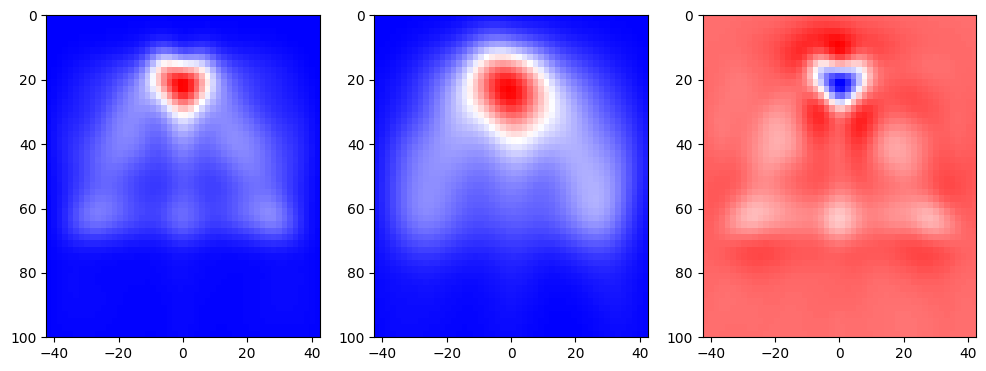

In [34]:
y_min, y_max = -42.5, 42.5
x_min, x_max = 0, 100


def get_kde(x_shots, y_shots):

   X, Y = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
   positions = np.vstack([X.ravel(), Y.ravel()])
   values = np.vstack([x_shots, y_shots])
   kernel = stats.gaussian_kde(values)
   Z = np.reshape(kernel(positions).T, X.shape)
   return Z

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

kde_season = get_kde(x_shots_season, y_shots_season)
ax[0].imshow(kde_season, cmap='bwr', extent=[y_min, y_max, x_min, x_max])
# ax[0].plot(y_shots_season, x_shots_season, 'k.', markersize=2)
ax[0].set_xlim([y_min, y_max])
ax[0].set_ylim([x_max, x_min])

kde_team = get_kde(x_shots_one_team, y_shots_one_team)
ax[1].imshow(kde_team, cmap='bwr', extent=[y_min, y_max, x_min, x_max])
# ax[1].plot(y_shots_one_team, x_shots_one_team, 'k.', markersize=2)
ax[1].set_xlim([y_min, y_max])
ax[1].set_ylim([x_max, x_min])

kde_diff = (kde_team - kde_season) 
ax[2].imshow(kde_diff, cmap='bwr', extent=[y_min, y_max, x_min, x_max])
# ax[2].plot(y_shots_one_team, x_shots_one_team, 'k.', markersize=2)
ax[2].set_xlim([y_min, y_max])
ax[2].set_ylim([x_max, x_min])
plt.show()


In [775]:
kde_diff.max()

0.000111974704273083

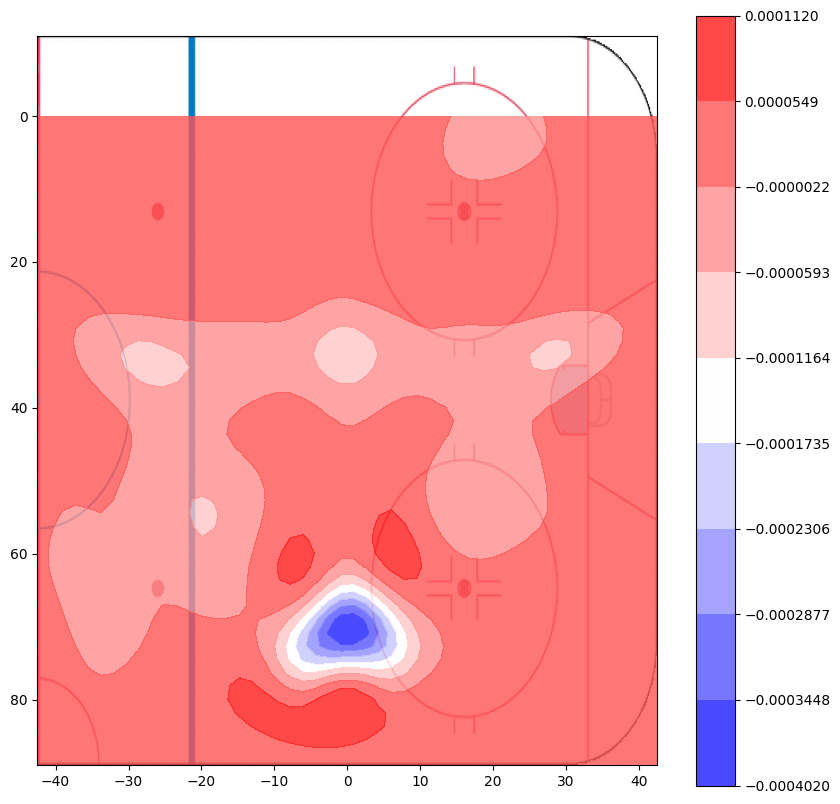

In [767]:
x_min, x_max = 0, 89
y_min, y_max = -42.5, 42.5

y_grid, x_grid = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]

fig = plt.figure(figsize=(10,10))
# plt.contourf(x_grid, y_grid, kde_season, alpha=0.8, cmap='bwr', levels = np.linspace(kde_season.min(), kde_season.max(), 10), vmin=kde_season.min(), vmax=kde_season.max())
plt.contourf(x_grid, y_grid, kde_diff, alpha=0.8, cmap='bwr', levels = np.linspace(kde_diff.min(), kde_diff.max(), 10), vmin=kde_diff.min(), vmax=kde_diff.max())
plt.colorbar(orientation = 'vertical')
plt.imshow(rink_half_img, extent=[-42.5, 42.5, 89, -11])